# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
import pandas as pd 
import seaborn as sns 
import itertools
from abstract_udmis import AbstractUDMIS

%matplotlib inline
sns.set(rc={'figure.figsize':(15,12)})

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [2]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges

    def get_edges(self):
        edges = list()
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges.append([i,j])
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        

In [3]:
u = 1.35
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

6


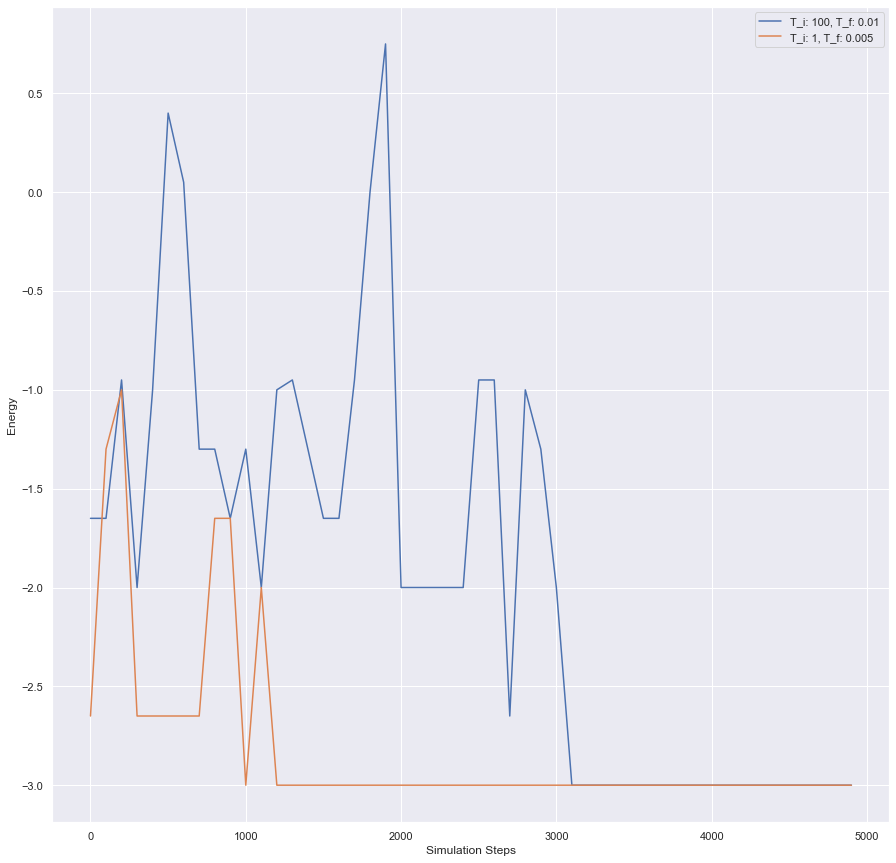

In [36]:
N = 5000
udmis = UDMIS(u, graph)
# T_i_list = [100, 10, 1000, 500, 50, 5, 1]
# T_i_list = [100, 1]
# T_i_list = [1]
# T_f_list = [0.01, 0.001, 0.1, 0.5, 1]
# T_f_list = [0.01, 0.005]

# params_list = list(itertools.product(T_i_list, T_f_list))

# params_list = [[100, 0.01]]
# params_list = [[100, 0.01], [1, 0.01]]
# params_list = [[100, 0.01], [100, 0.005]]
params_list = [[100, 0.01], [1, 0.005]]
# params_list = [[1, 0.005]]

convergence_points = list()
legend_labels = list()
occupation_list = list()
try:
    for T_i, T_f in params_list:
        
        t = np.arange(N+1)
        T = T_i * ((T_f/T_i) ** (t/N))
        # print(T)
        simulation_steps = []
        for t in range(N):
            # take a look at the abstract_udmis.py file to see how mc_step works
            
            temp = T[t]
            E = udmis.mc_step(T=temp)

            if t % 100 == 0:
                # print(t, E, udmis.occupations)
                simulation_steps.append({'Simulation Steps':t, 'Energy': E, 'Occupations': udmis.occupations})

            occupations_rep = ""
            for i in udmis.occupations:
                occupations_rep = occupations_rep+str(int(i))
            
            occupation_list.append(occupations_rep)
        simulation_steps_df = pd.DataFrame(simulation_steps)
        fig = sns.lineplot(data=simulation_steps_df, x="Simulation Steps", y="Energy")
        new_legend = 'T_i: {0}, T_f: {1}'.format(T_i, T_f)
        legend_labels.append(new_legend)
        
    fig.legend(legend_labels)
        
except Exception as e:
    print(T_i, T_f)
    print(T)
    print(e)

## Evaluate Solution Occupations & Plot their distributions

In [6]:
occupations_df = pd.Series(occupation_list)
occupations_top_df = occupations_df.value_counts()[occupations_df.value_counts()> 200]
occupations_top_df.name = 'Occupations'
occupations_top_df

101010    2577
001110     984
001011     600
dtype: int64

Text(0.5, 1.0, 'Solution Occupations Distribution - Simulated Annealing')

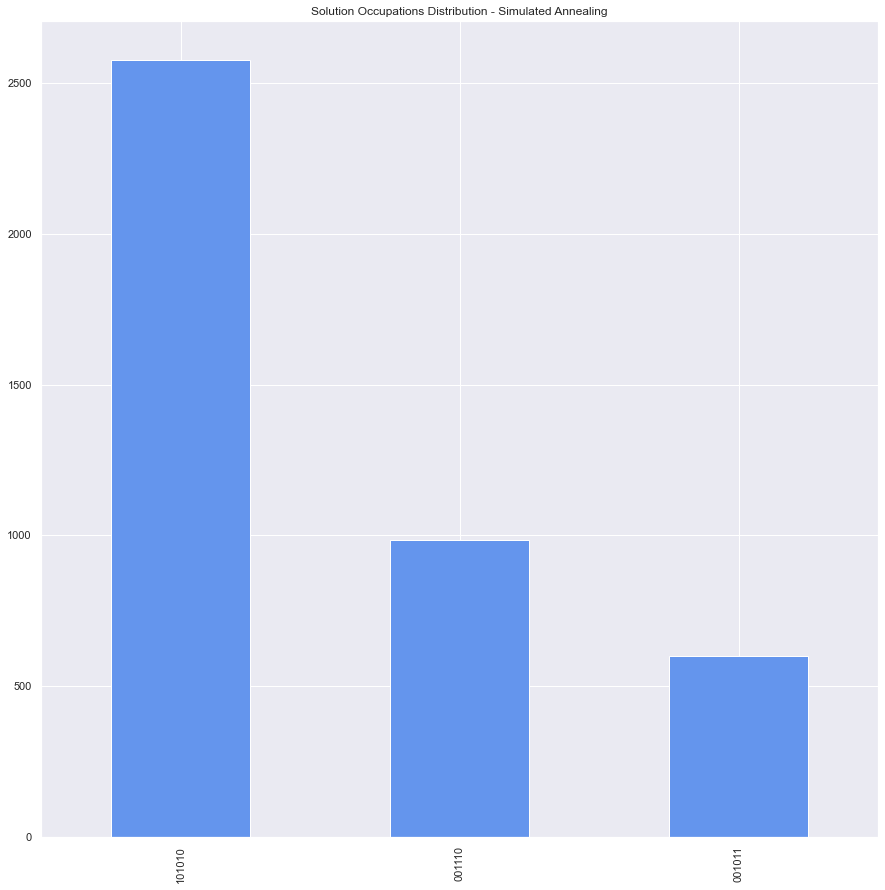

In [38]:
fig = occupations_top_df.plot(kind='bar', color='cornflowerblue')
fig.set_title('Solution Occupations Distribution - Simulated Annealing')


## Plot Solution Occupations


6


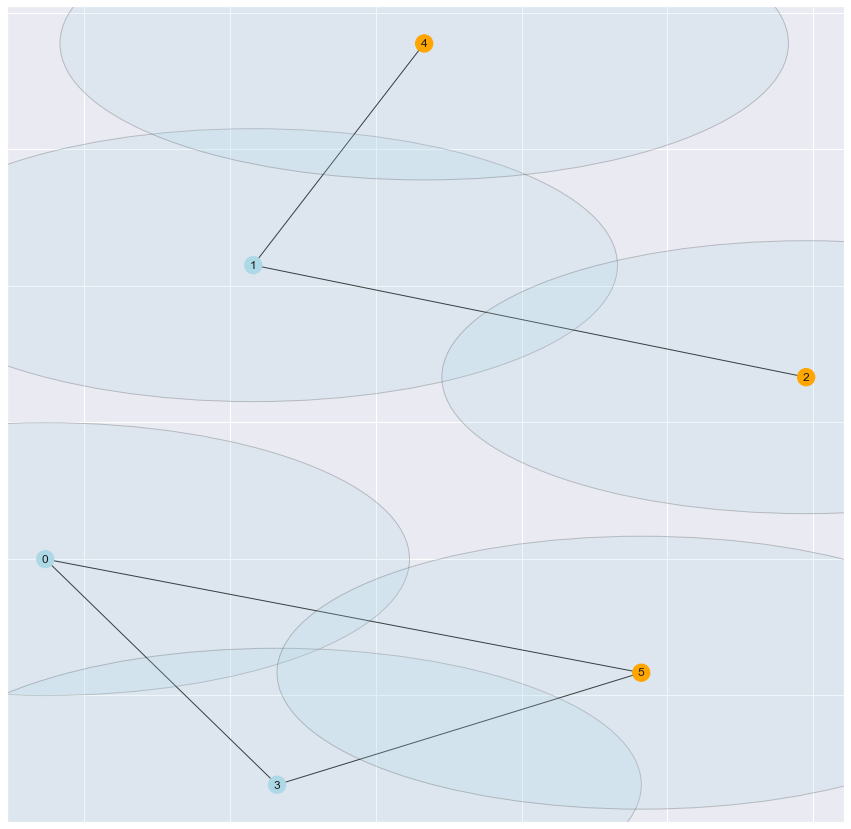

In [24]:
sns.set(rc={'figure.figsize':(15,15)})
udmis = UDMIS(u, graph)
vertices = list(range(udmis.num_vertices))
G = nx.Graph() 
G.add_nodes_from(vertices)
edge_list = udmis.get_edges()
for edge in edge_list:
    G.add_edge(edge[0],edge[1])

color_map = list()

for node in occupations_top_df.index[2]:
    if node == '0':
        color_map.append('lightblue')
    else: 
        color_map.append('orange')

fig, ax = plt.subplots(1, 1)
ax1 = nx.draw_networkx(G, pos=pos, with_labels=True, node_color=color_map)
for node in G.nodes():
    ax.add_artist(Circle(xy=pos[node], radius=.5, 
    facecolor='lightblue', alpha=0.2, edgecolor='black'))
plt.grid('on')
plt.show()